<a href="https://colab.research.google.com/github/Endrew-42/farmtech-fase6/blob/main/CNN_do_zero01_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esta célula é responsável por configurar o ambiente inicial. Ela baixa o arquivo compactado (.zip) que contém todo o dataset de imagens (treino, validação e teste) e o descompacta em um diretório de trabalho específico (/content/arquivos), garantindo que os dados estejam prontos para serem acessados pelas etapas seguintes.

Caso apareça a seguinte mensagem para você durante a execução da célula 1: "replace /content/arquivos/colab_fase6_cap1/arquivos/teste/rotated_frame00176.png? [y]es, [n]o, [A]ll, [N]one, [r]ename:" é porque você já baixou o arquivo ZIP e ele está tentando baixar novamente, a resposta mais segura nesse caso seria "A" pois ele vai substituir o arquivo zip anterior, o que é útil caso na tentativa anterior de baixar o arquivo ZIP tenha ocorrido algum problema com o download.

In [ ]:
# Célula 1: Baixar e descompactar os arquivos do zip
!pip install gdown
import gdown
gdown.download('https://drive.google.com/uc?id=1IIBVb_WyhxokNdHeF3kerjOHCpL_Y8GK', '/content/colab_fase6_cap1.zip', quiet=False)
!unzip /content/colab_fase6_cap1.zip -d /content/arquivos

Downloading...
From (original): https://drive.google.com/uc?id=1IIBVb_WyhxokNdHeF3kerjOHCpL_Y8GK
From (redirected): https://drive.google.com/uc?id=1IIBVb_WyhxokNdHeF3kerjOHCpL_Y8GK&confirm=t&uuid=c002ac56-27f3-406b-817e-447a1b06bba8
To: /content/colab_fase6_cap1.zip
100%|██████████| 254M/254M [00:03<00:00, 74.1MB/s]


Archive:  /content/colab_fase6_cap1.zip
   creating: /content/arquivos/colab_fase6_cap1/arquivos/labels/
  inflating: /content/arquivos/colab_fase6_cap1/arquivos/teste/rotated_frame00176.png  
  inflating: /content/arquivos/colab_fase6_cap1/arquivos/teste/frame00116.png  
  inflating: /content/arquivos/colab_fase6_cap1/arquivos/teste/rotated_frame00226.png  
  inflating: /content/arquivos/colab_fase6_cap1/arquivos/teste/rotated_frame00181.png  
  inflating: /content/arquivos/colab_fase6_cap1/arquivos/caneca_pote.yaml  
  inflating: /content/arquivos/colab_fase6_cap1/arquivos/teste/frame00161.png  
  inflating: /content/arquivos/colab_fase6_cap1/arquivos/imagens/val.cache  
  inflating: /content/arquivos/colab_fase6_cap1/arquivos/teste/frame00026.png  
  inflating: /content/arquivos/colab_fase6_cap1/arquivos/imagens/val/rotated_frame00456.txt  
  inflating: /content/arquivos/colab_fase6_cap1/arquivos/imagens/val/frame00156.txt  
  inflating: /content/arquivos/colab_fase6_cap1/arquivos/i

Garante que as imagens de teste estejam separadas em subpastas de classe (caneca e pote), um formato obrigatório para que o carregador de dados do TensorFlow/Keras consiga inferir corretamente os rótulos de cada imagem.

In [ ]:
# Célula: Mover imagens para subpastas Caneca e Pote
import os
import shutil

# Diretórios
source_dir = '/content/arquivos/colab_fase6_cap1/arquivos/teste/'
caneca_dir = os.path.join(source_dir, 'caneca')
pote_dir = os.path.join(source_dir, 'pote')

# Criar subpastas se não existirem
os.makedirs(caneca_dir, exist_ok=True)
os.makedirs(pote_dir, exist_ok=True)

# Mover imagens
for filename in os.listdir(source_dir):
    if filename.endswith('.png'):
        if filename.startswith('frame'):
            shutil.move(os.path.join(source_dir, filename), os.path.join(caneca_dir, filename))
        elif filename.startswith('rotated'):
            shutil.move(os.path.join(source_dir, filename), os.path.join(pote_dir, filename))

# Verificar resultado
print("Conteúdo de teste após movimentação:")
!ls -R /content/arquivos/colab_fase6_cap1/arquivos/teste/

Conteúdo de teste após movimentação:
/content/arquivos/colab_fase6_cap1/arquivos/teste/:
caneca	pote

/content/arquivos/colab_fase6_cap1/arquivos/teste/caneca:
frame00026.png	frame00116.png	frame00161.png	frame00481.png

/content/arquivos/colab_fase6_cap1/arquivos/teste/pote:
rotated_frame00016.png	rotated_frame00181.png
rotated_frame00176.png	rotated_frame00226.png


Esta célula realiza a conversão essencial de um formato de dataset (YOLO, com imagens e rótulos separados) para o formato exigido pelo Keras para Classificação: imagens organizadas em subpastas de classe (Caneca e Pote).

In [ ]:
# Célula 2: Preparar dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil

# Diretórios base
base_dir = '/content/arquivos/colab_fase6_cap1/arquivos/'
train_dir = os.path.join(base_dir, 'imagens/treino')
val_dir = os.path.join(base_dir, 'imagens/val')
test_dir = os.path.join(base_dir, 'teste')

# Criar estrutura de pastas por classe
for dir_path in [train_dir, val_dir, test_dir]:
    for class_name in ['Caneca', 'Pote']:
        os.makedirs(os.path.join(dir_path, class_name), exist_ok=True)

# Função para organizar imagens com base nos rótulos .txt
def organize_images(source_dir, target_dir):
    for img_file in os.listdir(source_dir):
        if img_file.endswith('.png'):
            txt_file = img_file.replace('.png', '.txt')
            txt_path = os.path.join(source_dir, txt_file)
            if os.path.exists(txt_path):
                with open(txt_path, 'r') as f:
                    label = int(f.readline().split()[0])  # 0 = Caneca, 1 = Pote
                    class_name = 'Caneca' if label == 0 else 'Pote'
                    shutil.copy(os.path.join(source_dir, img_file), os.path.join(target_dir, class_name, img_file))

# Organizar dados
organize_images(train_dir, train_dir)
organize_images(val_dir, val_dir)
organize_images(test_dir, test_dir)

# Geradores de dados
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)  # 10% para validação interna, se necessário
train_gen = datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
val_gen = datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
test_gen = datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='binary', shuffle=False)

print("Dataset preparado com sucesso!")

Found 190 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 8 images belonging to 4 classes.
Dataset preparado com sucesso!


Esta célula constrói a arquitetura completa da Rede Neural Convolucional (CNN) do zero e a prepara para o treinamento, definindo como ela aprenderá e como seu desempenho será medido.

In [ ]:
# Célula 3: Definir e compilar modelo
from tensorflow.keras import Sequential, layers

model = Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # 2 classes (Caneca e Pote)
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,391,329 (9.12 MB)

 Trainable params: 2,391,329 (9.12 MB)

 Non-trainable params: 0 (0.00 B)

Esta célula inicia o processo de aprendizado da CNN (model.fit) e utiliza o mecanismo Early Stopping para controlar a duração do treinamento, garantindo que o modelo pare de treinar assim que o desempenho parar de melhorar na validação, prevenindo o overfitting e otimizando o tempo.

In [ ]:
# Célula 4: Treinar modelo
from tensorflow.keras.callbacks import EarlyStopping
import time

es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
start_time = time.time()
history = model.fit(train_gen, epochs=2, validation_data=val_gen, callbacks=[es])
train_time = time.time() - start_time
print(f'Tempo de treinamento: {train_time:.2f} segundos')

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5393 - loss: 0.8669 - val_accuracy: 1.0000 - val_loss: 0.5085
Epoch 2/2
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9540 - loss: 0.4324 - val_accuracy: 1.0000 - val_loss: 0.0958
Tempo de treinamento: 28.96 segundos


Esta célula realiza a etapa final do processo de classificação: avaliar o desempenho real do modelo no conjunto de Teste e diagnosticar seus erros através da visualização da Matriz de Confusão.

Gerando previsões no conjunto de teste...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


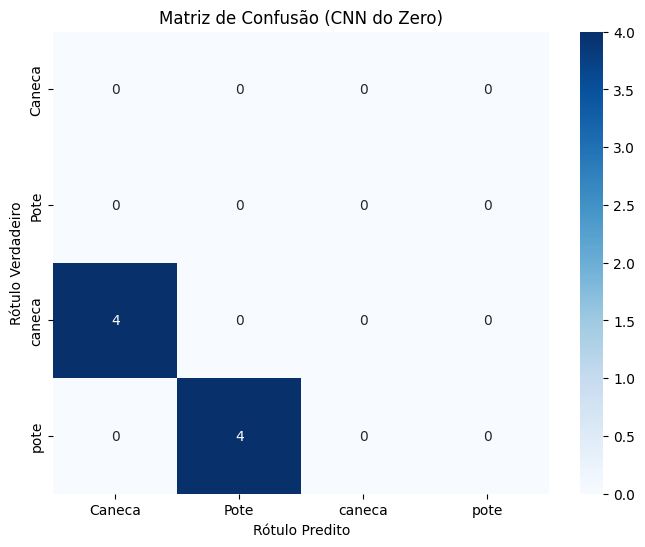

In [ ]:
print("Gerando previsões no conjunto de teste...")
predictions = model.predict(test_gen)

# Converter probabilidades em classes
y_pred_classes = (predictions > 0.5).astype(int).ravel()

# Rótulos verdadeiros
y_true = test_gen.labels

# Matriz de confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred_classes)
class_names = list(test_gen.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão (CNN do Zero)')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Predito')
plt.show()
